In [1]:
import pandas as pd
import numpy as np
import atmos
import units
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go 

pyo.init_notebook_mode(connected=True)

In [2]:
duration = 750  # [s]
timestep = 0.1  # [s]

gas_constant = 287  # [J/kg/K] gas constant for air
gamma = 1.2

# constants
g0 = 9.81  # [m/s/s]
Re = 6378000  # [m]

# engine definition
Isp = 366  # [s]
nengines = 2
thrust_sl = nengines*490000  # [N] (BE-4 550000 lbf at sea-level)
Ae = 1  # [m^2]
pe = units.Value(101325.0,'Pa')  # [atm]
mdot = thrust_sl/(g0*Isp)  # [kg/s]
mstructure = 20000  # [kg]
mpayload = 6000  # [kg]
burntime = [140, 50]  # [s] three burns, launch, reentry, landing
totalburn = sum(burntime)
mprop = mdot*totalburn  # [kg]
m0 = mstructure + mpayload + mprop
mf = m0 - mprop # [kg]
massratio = mprop/m0
print('mass ratio =', massratio)
print('num passengers =', mpayload//200)
atm = atmos.SimpleAtmos()

# vehicle stuff
S = 10  # [m^2] surface area
max_accel = 1*g0  # maximum acceleration (2g)

print('mass prop =', mprop)

mass ratio = 0.6660658004329499
num passengers = 30
mass prop = 51859.65029550531


In [3]:
def calc_thrust(thrust_sl, Ae, pe, pa):
    return thrust_sl + (pe-pa)*Ae

def calc_dV():
    thrust*np.cos(epsilon)
    
def calc_drag(U,gamma,R,T,rho,Cd,sos):
    if T == 0:
        return 0
    M = U/sos
    return 1/2*rho*U**2*S*Cd

def startLandingBurn(alt, vel, amax):
    try:
        alt2 = 500 
        vel2 = -25
        deltah = (vel2**2-vel**2)/(2*amax)
        if (alt + deltah) <= alt2:
            return True
        else:
            return False
    except:
        return -1

In [4]:
#
# standard atmosphere model (SI units)
#
def STDATM(altitude):
    R_air = 287             # gas constant [J/kg/K]
    gamma_air = 1.4         # ratio of specific heats
    g0 = 9.8                # gravity constant [m/s]
     
    layer = -1.0            # gradient layer
    gradient = -0.0065
    altitude_base = 0.0
    temperature_base = 288.16
    density_base = 1.2250
    
    if altitude > 11000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 11000.0
        temperature_base = 216.66
        density_base = 0.3648 
    elif altitude > 25000.0:
        layer = -1.0      # gradient layer
        gradient = 0.003
        altitude_base = 25000.0
        temperature_base = 216.66
        density_base = 0.04064
    
    elif altitude > 47000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 47000.0
        temperature_base = 282.66
        density_base = 0.001476
    elif altitude > 53000.0:
        layer = -1.0      # gradient layer
        gradient = -0.0045
        altitude_base = 53000.0
        temperature_base = 282.66
        density_base = 0.0007579
    elif altitude > 79000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 79000.0
        temperature_base = 165.66
        density_base = 0.0000224    
    elif altitude > 90000.0:
        layer = -1.0      # gradient layer
        gradient = 0.004
        altitude_base = 90000.0
        temperature_base = 165.66
        density_base = 0.00000232
    if layer < 0.0:
        temperature = temperature_base + gradient*(altitude - altitude_base)
        power = -1.0*(g0/gradient/R_air + 1.0)
        density = density_base*(temperature/temperature_base)**power
    else:
        temperature = temperature_base
        power = -1.0*g0*(altitude - altitude_base)/R_air/temperature
        density = density_base*np.exp(power)
    sos = np.sqrt(gamma_air*R_air*temperature)
    
    return (temperature, density, sos)

In [5]:
mass = [m0]
velocity = [0]
thrust = [thrust_sl]
altitude = [0]
R = []
thrust_angle = 0
drag = [0]
heading = np.deg2rad(90)
dynamicPressure = [0]
heatInput = [0]
machNumber = [0]
T,rho,sos = STDATM(0)
stagnationTemperature = [T]

accel = [0]
gravityterm = []

timearray = [0]
landingBurnStarted = False

i = 0  # iterator
for time in np.linspace(0,duration,num=duration/timestep+1):
    R.append(Re+altitude[i])
    dVdt = ((thrust[i]*np.cos(thrust_angle)-drag[i])/mass[i] - g0*(Re/R[i])**2*np.sin(heading))
    dV = dVdt*timestep
    accel.append(dVdt)
    
    gravityterm.append((-g0*(Re/R[i])**2*np.sin(heading))*timestep)
    
    dalt = velocity[i]*np.sin(heading)*timestep
    altitude.append(altitude[i]+dalt)
    velocity.append(velocity[i]+dV)

    T, rho, sos = STDATM(altitude[i])
    
    M = velocity[i]/sos
    machNumber.append(abs(M))
    Cd = 0.15 + 0.6*M**2*np.exp(-M**2)
    drag.append(calc_drag(velocity[i], gamma, gas_constant, T, rho, Cd, sos))

    dynamicPressure.append(1/2*rho*velocity[i]**2)
    
    
    stagnationTemperature.append(T*(1+(gamma-1)/2*M**2))
    heatInput.append(1/2*dynamicPressure[i]*abs(velocity[i])*S*Cd/3)
    
    timearray.append(time)
    
    if altitude[i]<20 and time>burntime[0]:
        pa = atm.pressure(0,'m')
        thrust.append(0)
        mass.append(mass[i])
        break
    else:
        pa = atm.pressure(altitude[i],'m')
    if time < burntime[0]:
        """ Launch burn """
        thrust.append(calc_thrust(thrust_sl,Ae,pe.SIValue,pa.SIValue))
        mass.append(mass[i]-mdot*timestep)
    elif (startLandingBurn(altitude[i], velocity[i], max_accel) or landingBurnStarted) and velocity[i] < -25:
        """ Landing burn """
        if not landingBurnStarted:
            landingBurnStarted = True
            landingBurnStartTime = time
        currentThrust = (max_accel + g0*(Re/R[i])**2*np.sin(heading))*mass[i]+drag[i]/np.cos(thrust_angle)
        thrustRatio = currentThrust/thrust_sl
        thrust.append(currentThrust)
        mass.append(mass[i]-thrustRatio*mdot*timestep)
    elif landingBurnStarted and velocity[i] < -5 and altitude[i] <= 100:
        """ when less than 25 meters above the ground, slow vehicle with thrust=1.2*(weight+drag)"""
        currentThrust = (max_accel/2 + g0*(Re/R[i])**2*np.sin(heading))*mass[i]+drag[i]/np.cos(thrust_angle)
        thrustRatio = currentThrust/thrust_sl
        thrust.append(currentThrust)
        mass.append(mass[i]-thrustRatio*mdot*timestep)
    elif landingBurnStarted and velocity[i] >= -5 and altitude[i] <= 100:
        """ when 25 m above the ground and velocity is less than 5m/s, continue at a constant thrust """
        currentThrust = (g0*(Re/R[i])**2*np.sin(heading))*mass[i]+drag[i]/np.cos(thrust_angle)
        thrustRatio = currentThrust/thrust_sl
        thrust.append(currentThrust)
        mass.append(mass[i]-thrustRatio*mdot*timestep)
    elif landingBurnStarted:
        """ if the landing burn has started but not in one of the other conditions,
        maintain current velocity with thrust=(weight+drag)"""
        currentThrust = (g0*(Re/R[i])**2*np.sin(heading))*mass[i]+drag[i]/np.cos(thrust_angle)
        thrustRatio = currentThrust/thrust_sl
        thrust.append(currentThrust)
        mass.append(mass[i]-thrustRatio*mdot*timestep)
    else:
        thrust.append(0)
        mass.append(mass[i])   
    i += 1
    
print('Done.')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



Done.


379.3 63.1508075136


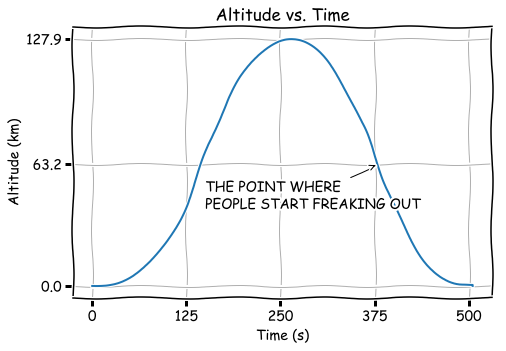

In [6]:
kmaltitude = [x/1000 for x in altitude]
nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.grid(linewidth=1.0)
ax.yaxis.grid(linewidth=1.0)
ax.grid(True, linewidth=1)

print(landingBurnStartTime,kmaltitude[timearray.index(landingBurnStartTime)])
plt.annotate(
    'THE POINT WHERE\nPEOPLE START FREAKING OUT',
    xy=(landingBurnStartTime,kmaltitude[timearray.index(landingBurnStartTime)]),
    arrowprops=dict(arrowstyle='->'), xytext=(150,40))

plt.plot(timearray,kmaltitude)

plt.title('Altitude vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.show()
fig.savefig('altitude-time.png')

In [8]:
def plot_events(ax, timearray, landingBurnStartTime, burntime, altitude, thing):
    """ create vertical lines at events """
    xburnout = [burntime[0], burntime[0]]
    yburnout = [0, thing[timearray.index(burntime[0])]]

    xapogee = [timearray[altitude.index(max(altitude))], timearray[altitude.index(max(altitude))]]
    yapogee = [0, thing[altitude.index(max(altitude))]]

    xlanding = [landingBurnStartTime, landingBurnStartTime]
    ylanding = [0, thing[timearray.index(landingBurnStartTime)]]

    ax.plot(xburnout, yburnout, 'r', xapogee, yapogee, 'r', xlanding, ylanding, 'r')
    return 0

def plot_maxq(ax, q):
    launchq = q[0:len(q)//2]
    entryq = q[len(q)//2:len(q)-1]
    
    xlaunch = [timearray[q.index(max(launchq))],timearray[q.index(max(launchq))]]
    ylaunch = [0,max(launchq)]
    
    xentry = [timearray[q.index(max(entryq))],timearray[q.index(max(entryq))]]
    yentry = [0, max(entryq)]
    
    ax.plot(xlaunch, ylaunch, 'r')
    ax.plot(xentry, yentry,'r')
    
    return (timearray[q.index(max(launchq))], max(launchq), timearray[q.index(max(entryq))], max(entryq))

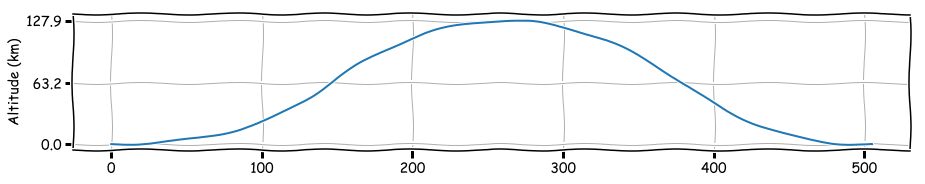

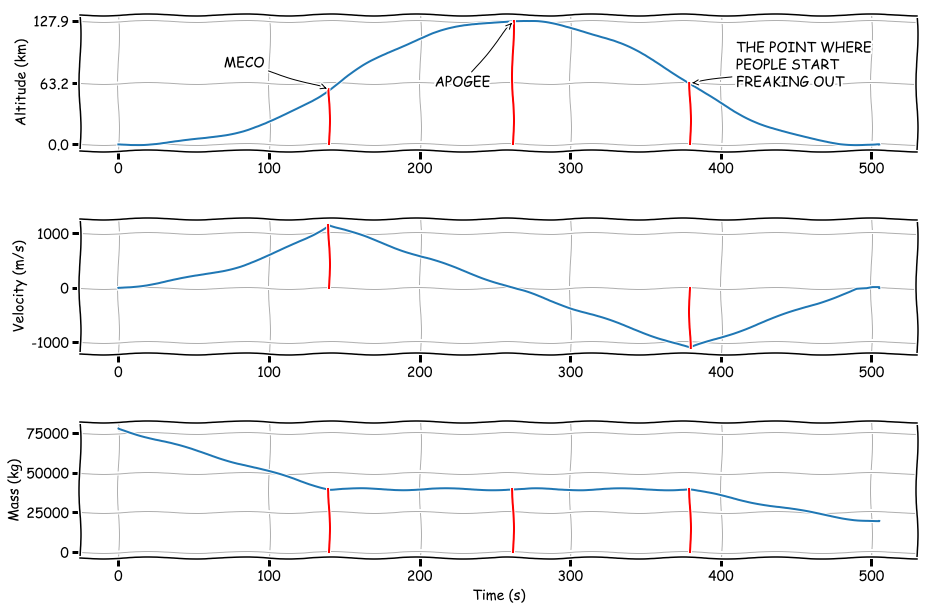

In [9]:
kmaltitude = [x/1000 for x in altitude]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
# ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.grid(linewidth=1.0)
ax1.yaxis.grid(linewidth=1.0)
ax1.grid(True, linewidth=1)

# plot altitude
ax1.plot(timearray,kmaltitude)
ax1.set_ylabel('Altitude (km)')
ax1.annotate(
    'MECO',
    xy=(burntime[0],kmaltitude[timearray.index(burntime[0])]),
    arrowprops=dict(arrowstyle='->'), xytext=(70,80))
ax1.annotate(
    'APOGEE',
    xy=(timearray[kmaltitude.index(max(kmaltitude))],max(kmaltitude)),
    arrowprops=dict(arrowstyle='->'), xytext=(210,60))
ax1.annotate(
    'THE POINT WHERE\nPEOPLE START\nFREAKING OUT',
    xy=(landingBurnStartTime,kmaltitude[timearray.index(landingBurnStartTime)]),
    arrowprops=dict(arrowstyle='->'), xytext=(410,60))
plot_events(ax1, timearray, landingBurnStartTime, burntime, kmaltitude, kmaltitude)

# plot velocity
ax2 = fig.add_subplot(3, 1, 2)
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)
ax2.plot(timearray,velocity)
ax2.set_ylabel('Velocity (m/s)')
plot_events(ax2, timearray, landingBurnStartTime, burntime, kmaltitude, velocity)

# plot mass
ax3 = fig.add_subplot(3,1,3)
ax3.xaxis.grid(linewidth=1.0)
ax3.yaxis.grid(linewidth=1.0)
ax3.grid(True, linewidth=1)
ax3.plot(timearray,mass)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Mass (kg)')
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, mass)

plt.show()
fig.savefig('alt-vel-mass.png')

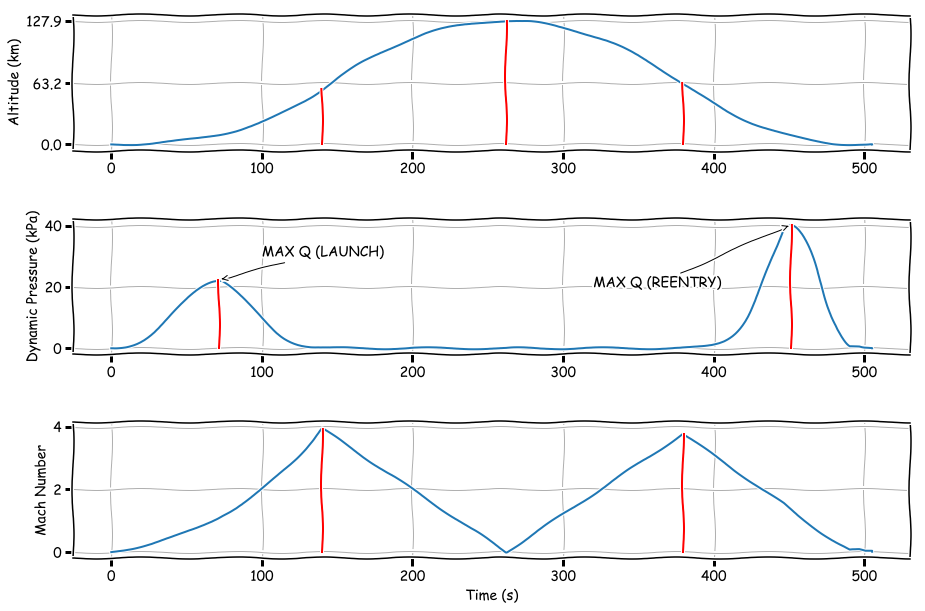

In [10]:
kmaltitude = [x/1000 for x in altitude]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
# ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.grid(linewidth=1.0)
ax1.yaxis.grid(linewidth=1.0)
ax1.grid(True, linewidth=1)

# plot altitude
ax1.plot(timearray,kmaltitude)
ax1.set_ylabel('Altitude (km)')
# ax1.annotate(
#     'MECO',
#     xy=(burntime[0],kmaltitude[timearray.index(burntime[0])]),
#     arrowprops=dict(arrowstyle='->'), xytext=(70,80))
# ax1.annotate(
#     'APOGEE',
#     xy=(timearray[kmaltitude.index(max(kmaltitude))],max(kmaltitude)),
#     arrowprops=dict(arrowstyle='->'), xytext=(210,60))
# ax1.annotate(
#     'THE POINT WHERE\nPEOPLE START\nFREAKING OUT',
#     xy=(landingBurnStartTime,kmaltitude[timearray.index(landingBurnStartTime)]),
#     arrowprops=dict(arrowstyle='->'), xytext=(410,60))
plot_events(ax1, timearray, landingBurnStartTime, burntime, kmaltitude, kmaltitude)

# plot dynamic pressure
kdynamicPressure = [x/1000 for x in dynamicPressure]
ax2 = fig.add_subplot(3, 1, 2)
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)
ax2.plot(timearray,kdynamicPressure)
ax2.set_ylabel('Dynamic Pressure (kPa)')
(maxqLaunchx, maxqLaunchy, maxqEntryx, maxqEntryy) = plot_maxq(ax2,kdynamicPressure)
ax2.annotate(
    'MAX Q (LAUNCH)',
    xy=(maxqLaunchx, maxqLaunchy),
    arrowprops=dict(arrowstyle='->'), xytext=(100,30))
ax2.annotate(
    'MAX Q (REENTRY)',
    xy=(maxqEntryx, maxqEntryy),
    arrowprops=dict(arrowstyle='->'), xytext=(320,20))

# plot Mach Number
ax3 = fig.add_subplot(3,1,3)
ax3.xaxis.grid(linewidth=1.0)
ax3.yaxis.grid(linewidth=1.0)
ax3.grid(True, linewidth=1)
ax3.plot(timearray,machNumber)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Mach Number')
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, machNumber)


plt.show()
fig.savefig('alt-q-mach.png')

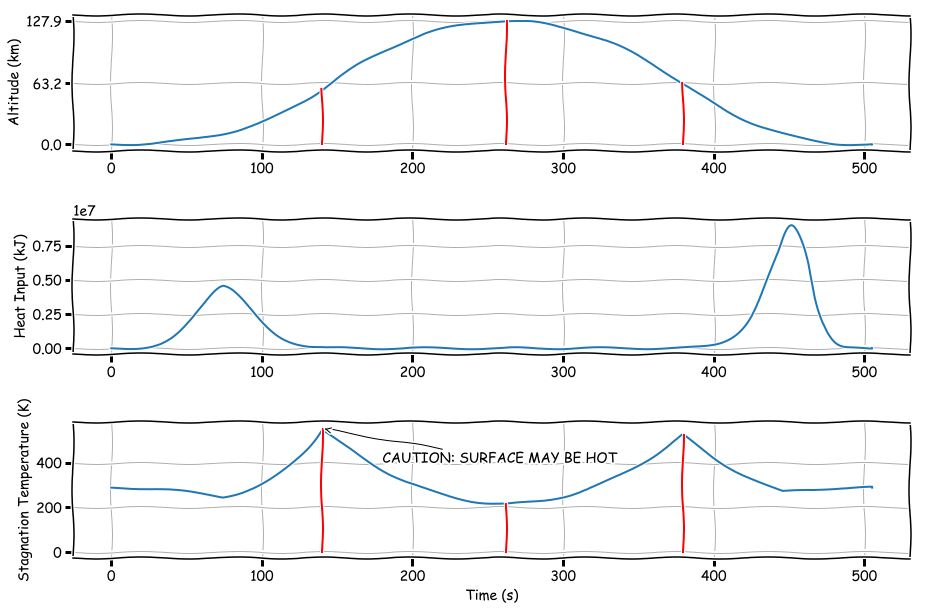

In [11]:
kmaltitude = [x/1000 for x in altitude]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
# ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.grid(linewidth=1.0)
ax1.yaxis.grid(linewidth=1.0)
ax1.grid(True, linewidth=1)

# plot altitude
ax1.plot(timearray,kmaltitude)
ax1.set_ylabel('Altitude (km)')
plot_events(ax1, timearray, landingBurnStartTime, burntime, kmaltitude, kmaltitude)

# plot Heat Input
kdynamicPressure = [x/1000 for x in dynamicPressure]
ax2 = fig.add_subplot(3, 1, 2)
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)
ax2.plot(timearray,heatInput)
ax2.set_ylabel('Heat Input (kJ)')
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, heatInput)

# plot Stagnation Temperature
ax3 = fig.add_subplot(3,1,3)
ax3.xaxis.grid(linewidth=1.0)
ax3.yaxis.grid(linewidth=1.0)
ax3.grid(True, linewidth=1)
ax3.plot(timearray,stagnationTemperature)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Stagnation Temperature (K)')
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, stagnationTemperature)
ax3.annotate(
    'CAUTION: SURFACE MAY BE HOT',
    xy=(timearray[stagnationTemperature.index(max(stagnationTemperature))],max(stagnationTemperature)),
    arrowprops=dict(arrowstyle='->'), xytext=(180,400))

plt.show()
fig.savefig('alt-heat-temp.png')

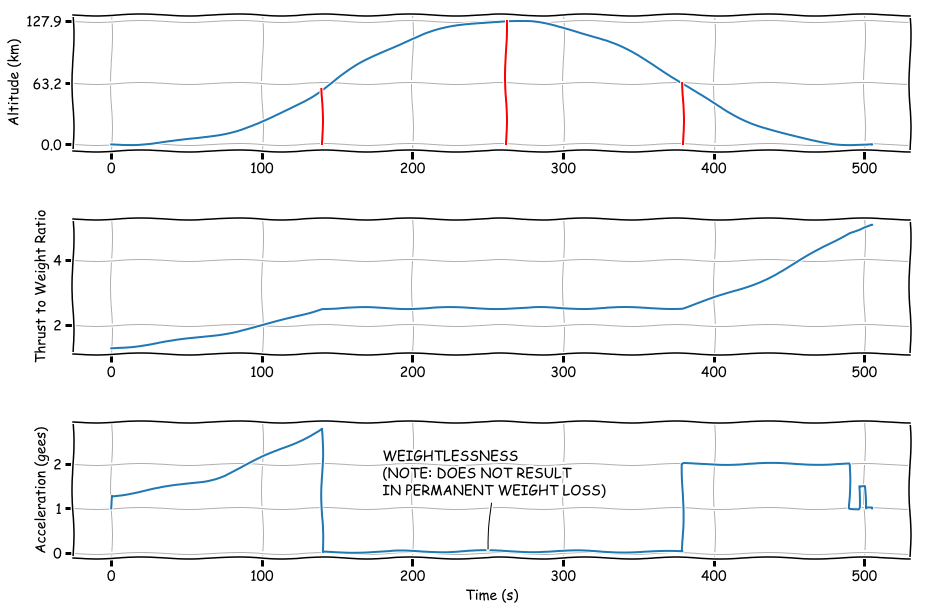

In [12]:
kmaltitude = [x/1000 for x in altitude]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
# ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.grid(linewidth=1.0)
ax1.yaxis.grid(linewidth=1.0)
ax1.grid(True, linewidth=1)

# plot altitude
ax1.plot(timearray,kmaltitude)
ax1.set_ylabel('Altitude (km)')
plot_events(ax1, timearray, landingBurnStartTime, burntime, kmaltitude, kmaltitude)

# Plot Thrust to Weight 
weight = [x*g0 for x in mass]
ratio = [thrust_sl/w for w in weight]
ax2 = fig.add_subplot(3, 1, 2)
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)
ax2.plot(timearray,ratio)
ax2.set_ylabel('Thrust to Weight Ratio')
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, ratio)

# plot acceleration in gees
gees = [(x+g0)/g0 for x in accel]
ax3 = fig.add_subplot(3,1,3)
ax3.xaxis.grid(linewidth=1.0)
ax3.yaxis.grid(linewidth=1.0)
ax3.grid(True, linewidth=1)
ax3.plot(timearray,gees)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Acceleration (gees)')
ax3.annotate(
    'WEIGHTLESSNESS\n(NOTE: DOES NOT RESULT\nIN PERMANENT WEIGHT LOSS)',
    xy=(250,gees[timearray.index(250)]),
    arrowprops=dict(arrowstyle='-'), xytext=(180,1.3))

plt.show()
fig.savefig('alt-twratio-accel.png')

In [13]:
kmaltitude = [x/1000 for x in altitude]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)
yticks = [0,max(kmaltitude),kmaltitude[timearray.index(landingBurnStartTime)]]

plt.xkcd()
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3, 1, 1)
# ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.grid(linewidth=1.0)
ax1.yaxis.grid(linewidth=1.0)
ax1.grid(True, linewidth=1)

# plot altitude
ax1.plot(timearray,kmaltitude)
ax1.set_ylabel('Altitude (km)')
plot_events(ax1, timearray, landingBurnStartTime, burntime, kmaltitude, kmaltitude)

# plot dynamic pressure
kdynamicPressure = [x/1000 for x in dynamicPressure]
ax2 = fig.add_subplot(3, 1, 2)
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)
ax2.plot(timearray,kdynamicPressure)
ax2.set_ylabel('Dynamic Pressure (kPa)')
(maxqLaunchx, maxqLaunchy, maxqEntryx, maxqEntryy) = plot_maxq(ax2,kdynamicPressure)

# plot Drag
kNdrag = [x/1000 for x in drag]

ax3 = fig.add_subplot(3,1,3)
ax3.xaxis.grid(linewidth=1.0)
ax3.yaxis.grid(linewidth=1.0)
ax3.grid(True, linewidth=1)
ax3.plot(timearray,kNdrag)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Drag (kN)')
# ax3.annotate(
#     'WEIGHTLESSNESS\n(NOTE: DOES NOT RESULT\nIN PERMANENT WEIGHT LOSS)',
#     xy=(250,gees[timearray.index(250)]),
#     arrowprops=dict(arrowstyle='-'), xytext=(180,1.3))
plot_events(ax3, timearray, landingBurnStartTime, burntime, kmaltitude, kNdrag)


plt.show()
fig.savefig('alt-q-drag.png')

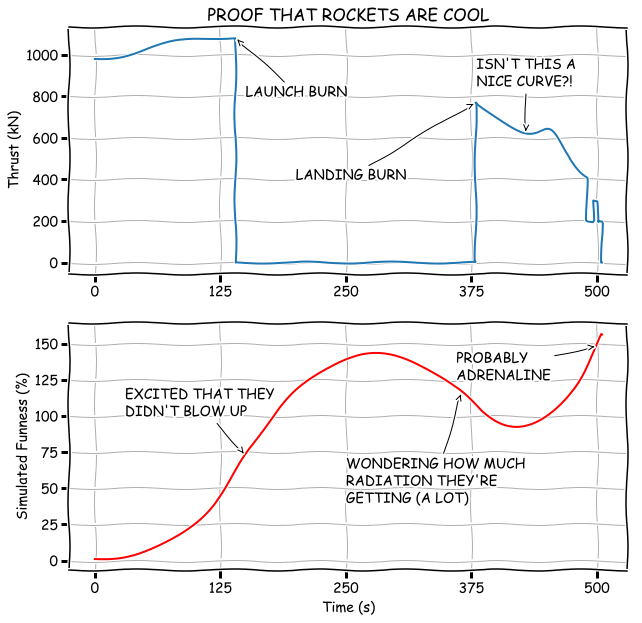

In [17]:
# Plot Thrust
kNthrust = [x/1000 for x in thrust]

nxticks = 5
xticks = np.linspace(0,int(timearray[len(timearray)-1]//10*10),num=nxticks)

plt.xkcd()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticks(xticks)
ax.xaxis.grid(linewidth=1.0)
ax.yaxis.grid(linewidth=1.0)
ax.grid(True, linewidth=1)

ax.annotate(
    'LANDING BURN',
    xy=(landingBurnStartTime,kNthrust[timearray.index(landingBurnStartTime)]),
    arrowprops=dict(arrowstyle='->'), xytext=(200,400))
ax.annotate(
    'LAUNCH BURN',
    xy=(burntime[0],kNthrust[timearray.index(burntime[0]-1)]),
    arrowprops=dict(arrowstyle='->'), xytext=(150,800))
ax.annotate(
    'ISN\'T THIS A\nNICE CURVE?!',
    xy=(landingBurnStartTime+50,kNthrust[timearray.index(landingBurnStartTime+50)]),
    arrowprops=dict(arrowstyle='->'), xytext=(380,850))
ax.plot(timearray,kNthrust)
ax.set_ylabel('Thrust (kN)')

funEstimation = [np.exp(x/100)+a for x, a in zip(timearray, kmaltitude)]
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xticks(xticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)

ax2.plot(timearray, funEstimation, 'r')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Simulated Funness (%)')

ax2.annotate(
    'EXCITED THAT THEY\nDIDN\'T BLOW UP',
    xy=(150,funEstimation[timearray.index(150)]),
    arrowprops=dict(arrowstyle='->'), xytext=(30,100))
ax2.annotate(
    'WONDERING HOW MUCH\nRADIATION THEY\'RE\nGETTING (A LOT)',
    xy=(365,funEstimation[timearray.index(365)]),
    arrowprops=dict(arrowstyle='->'), xytext=(250,40))
ax2.annotate(
    'PROBABLY\nADRENALINE',
    xy=(500,funEstimation[timearray.index(500)]),
    arrowprops=dict(arrowstyle='->'), xytext=(360,125))

ax.set_title('PROOF THAT ROCKETS ARE COOL')
plt.show()
fig.savefig('thrust-funness.png')

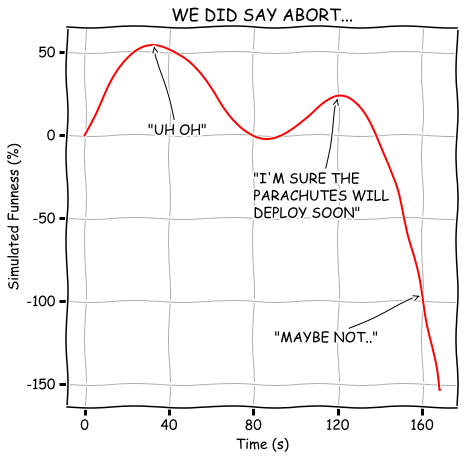

In [16]:
# Plot Off-Nominal Funness
anomalyTimeArray = [t/3 for t in timearray]

nxticks = 5
xticks = np.linspace(0,int(anomalyTimeArray[len(anomalyTimeArray)-1]//10*10),num=nxticks)

plt.xkcd()
fig = plt.figure(figsize=(7,7))
funEstimation = [(-np.exp(x/30)+a+100*np.sin(x/anomalyTimeArray[len(anomalyTimeArray)-1]*3*np.pi) - x/5)/2 for x, a in zip(anomalyTimeArray, kmaltitude)]
ax2 = fig.add_subplot(1, 1, 1)
ax2.set_xticks(xticks)
ax2.xaxis.grid(linewidth=1.0)
ax2.yaxis.grid(linewidth=1.0)
ax2.grid(True, linewidth=1)

ax2.plot(anomalyTimeArray, funEstimation, 'r')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Simulated Funness (%)')

ax2.annotate(
    '"UH OH"',
    xy=(anomalyTimeArray[funEstimation.index(max(funEstimation))],max(funEstimation)),
    arrowprops=dict(arrowstyle='->'), xytext=(30,-0))
ax2.annotate(
    '"I\'M SURE THE\nPARACHUTES WILL\nDEPLOY SOON"',
    xy=(120,funEstimation[anomalyTimeArray.index(120)]),
    arrowprops=dict(arrowstyle='->'), xytext=(80,-50))
ax2.annotate(
    '"MAYBE NOT.."',
    xy=(160,funEstimation[anomalyTimeArray.index(160)]),
    arrowprops=dict(arrowstyle='->'), xytext=(90,-125))
plt.title('WE DID SAY ABORT...')
plt.show()
fig.savefig('thrust-saddness.png')

In [138]:
apogeeTime = timearray[altitude.index(max(altitude))]
print('apogee time = %d' % apogeeTime)
print('landing time = %d' % max(timearray))
print('landing burn start = %d' % landingBurnStartTime)
print('landing burn length = %d' % (max(timearray)-landingBurnStartTime))

apogee time = 262
landing time = 505
landing burn start = 379
landing burn length = 125


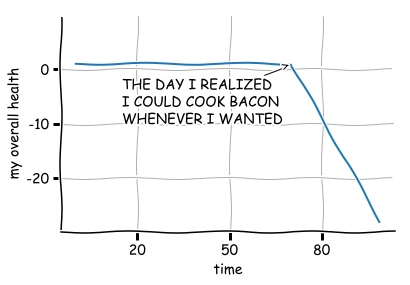

In [22]:
plt.xkcd()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
ax.set_ylim([-30, 10])
ax.set_xticks([20,50,80])
ax.set_yticks([-20,-10,0])
ax.xaxis.grid(linewidth=1.0)
ax.yaxis.grid(linewidth=1.0)
ax.grid(True, linewidth=1)

data = np.ones(100)
data[70:] -= np.arange(30)

plt.annotate(
    'THE DAY I REALIZED\nI COULD COOK BACON\nWHENEVER I WANTED',
    xy=(70, 1), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))

plt.plot(data)

plt.xlabel('time')
plt.ylabel('my overall health')

plt.show()

## xkcd example code

In [7]:
# Plot Drag
kNdrag = [x/1000 for x in drag]
trace = go.Scatter(
    x = timearray,
    y = kNdrag
)
data = [trace]
layout = dict(title = 'Drag',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Drag (kN)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = dynamicPressure
)
data = [trace]
layout = dict(title = 'Dynamic Pressure',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Dynamic Pressure Pa'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = machNumber
)
data = [trace]
layout = dict(title = 'Mach Number',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Mach Number'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = heatInput
)
data = [trace]
layout = dict(title = 'Heat Input',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Heat Input (kJ)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

In [6]:
# Plot Altitude
kmaltitude = [x/1000 for x in altitude]
# Create a trace
trace = go.Scatter(
    x = timearray,
    y = kmaltitude
)
data = [trace]
# Edit the layout
layout = dict(title = 'Altitude vs. Time',
    xaxis = dict(title = 'Time (s)'),
    yaxis = dict(title = 'Altitude (km)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='altitude-time_mae155a')

# Plot Thrust to Weight 
weight = [x*g0 for x in mass]
ratio = [thrust_sl/w for w in weight]
trace = go.Scatter(
    x = timearray,
    y = ratio
)
data = [trace]
layout = dict(title='Thrust to Weight Ratio',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Thrust/Weight'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig,filename='thrust-to-weight_mae155a')

# Plot Thrust
kNthrust = [x/1000 for x in thrust]
trace = go.Scatter(
    x = timearray,
    y = kNthrust
)
data =[trace]
layout = dict(title = 'Thrust vs. Time',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Thrust (kN)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig,filename='thrust-time_mae155a')

# Plot Acceleration
gees = [(x+g0)/g0 for x in accel]
trace = go.Scatter(
    x = timearray,
    y = gees
)
data = [trace]
layout = dict(title = 'Acceleration vs. Time',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Acceleration (gee\'s)'))
fig = dict(data=data,layout=layout)
pyo.iplot(fig, filename='acceleration-time_mae155a')

# Plot Velocity
trace = go.Scatter(
    x = timearray,
    y = velocity)
data = [trace]

layout = dict(title = 'Velocity vs. Time',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Velocity (m/s)'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='velocity-time_mae155a')

# Plot Mass
trace = go.Scatter(
    x = timearray,
    y = mass)
data = [trace]
layout = dict(title='Mass vs. Time',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Mass (kg)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='mass-time_mae155a')

In [190]:
funEstimation = [np.exp(x/100)+a for x, a in zip(timearray, kmaltitude)]
plt.xkcd()
fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticks(xticks)
ax.xaxis.grid(linewidth=1.0)
ax.yaxis.grid(linewidth=1.0)
ax.grid(True, linewidth=1)

ax.plot(timearray, funEstimation)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percent Fun')
ax.set_title('Simulated Funness')
plt.show()
fig.savefig('simulated_funness.png')

In [48]:
"""Examples illustrating the use of plt.subplots().

This function creates a figure and a grid of subplots with a single call, while
providing reasonable control over how the individual plots are created.  For
very refined tuning of subplot creation, you can still use add_subplot()
directly on a new figure.
"""

import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

plt.close('all')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

plt.show()
